In [ ]:
! mkdir ~/.kaggle

In [ ]:
!mv ./kaggle.json  ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c fathomnet-out-of-sample-detection

  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 76.2MB/s]


In [ ]:
!unzip fathomnet-out-of-sample-detection.zip

Archive:  fathomnet-out-of-sample-detection.zip
  inflating: category_key.csv        
  inflating: demo_download.ipynb     
  inflating: download_images.py      
  inflating: multilabel_classification/train.csv  
  inflating: object_detection/eval.json  
  inflating: object_detection/train.json  
  inflating: requirements.txt        
  inflating: sample_submission.csv   


# **Install lib**

In [ ]:
!pip install positional-encodings timm randaugment

# **Dataset download**

In [ ]:
import os
import json
import requests
from shutil import copyfileobj
from multiprocessing.pool import ThreadPool

In [ ]:
def read_json(filename):
    return json.load(open(filename, "r"))


def delete_empty_files(folder_path):
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and os.path.getsize(file_path) == 0:
            os.remove(file_path)


def download_image(image):
    if not os.path.exists(image[0]):
        resp = requests.get(image[1], stream=True)
        resp.raw.decode_content = True
        with open(image[0], 'wb') as f:
            copyfileobj(resp.raw, f)

In [ ]:
def valid_download():
    delete_empty_files("./imgs/valid/")
    valid_json = read_json("./object_detection/eval.json")
    valid_imgs = [
        ["./imgs/valid/"+i["file_name"], i["coco_url"]] for i in valid_json["images"] if not os.path.exists("./imgs/valid/"+i["file_name"])
    ]
    pool = ThreadPool(10000)
    results = pool.map(download_image, valid_imgs)
    pool.close()
    pool.join()

In [ ]:
def train_download():
    delete_empty_files("./imgs/train/")
    train_json = read_json("./object_detection/train.json")
    train_imgs = [
        ["./imgs/train/"+i["file_name"], i["coco_url"]] for i in train_json["images"] if not os.path.exists("./imgs/train/"+i["file_name"])
    ]
    pool = ThreadPool(10000)
    results = pool.map(download_image, train_imgs)
    pool.close()
    pool.join()

In [ ]:
if not os.path.exists("./imgs"):
    os.mkdir("./imgs")
    os.mkdir("./imgs/train/")
    os.mkdir("./imgs/valid/")
else:
    if not os.path.exists("./imgs/train/"):
        os.mkdir("./imgs/train/")

    if not os.path.exists("./imgs/valid/"):
        os.mkdir("./imgs/valid/")

In [ ]:
%%time
train_download()

CPU times: user 2min 27s, sys: 1min 34s, total: 4min 1s
Wall time: 2min 48s


In [ ]:
%%time 
valid_download()

CPU times: user 5min 54s, sys: 6min 8s, total: 12min 3s
Wall time: 8min 29s


In [ ]:
data = read_json("./object_detection/train.json")

In [ ]:
data.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [ ]:
categories = data['categories']
categories

# **Create Custom Dataset**

In [ ]:
import os
import json 
import torch
import random
import numpy as np
from PIL import Image, ImageDraw
from randaugment import RandAugment
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
class SLCutoutPIL(object):
    def __init__(self, n_holes, length, cut_fact=None):
        self.n_holes = n_holes
        self.length = length
        self.cut_fact = cut_fact
        if self.cut_fact is not None:
            assert length < 0, "length must be set to -1 but {} if cut_fact is not None!".format(length)

    def __call__(self, x):
        img_draw = ImageDraw.Draw(x)
        h, w = x.size[0], x.size[1]  # HWC
        if self.cut_fact is not None:
            h_cutout = int(self.cut_fact * h)
            w_cutout = int(self.cut_fact * w)
        else:
            h_cutout = int(self.length)
            w_cutout = int(self.length)
        for i in range(self.n_holes):
            y_c = np.random.randint(h)
            x_c = np.random.randint(w)

            y1 = np.clip(y_c - h_cutout // 2, 0, h)
            y2 = np.clip(y_c + h_cutout // 2, 0, h)
            x1 = np.clip(x_c - w_cutout // 2, 0, w)
            x2 = np.clip(x_c + w_cutout // 2, 0, w)
            fill_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            img_draw.rectangle([x1, y1, x2, y2], fill=fill_color)

        return x

In [ ]:
class FathomDataset(Dataset):


    def __init__(self, img_path, json_path, img_size, train_mode=False, **kwargs):
        super().__init__()
        self.img_path = img_path
        self._load_json_data(json_path)
        self.train_mode = train_mode
        if train_mode:
            self.num_classes = kwargs["num_classes"]
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                # SLCutoutPIL(n_holes=kwargs["n_holes"], length=kwargs["length"], cut_fact=0.5),
                RandAugment(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]) 
        else:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])


    def _load_json_data(self, json_path):
        self.json_data = json.load(open(json_path, "rb"))

    
    def __len__(self):
        return len(self.json_data["images"])


    def get_one_hot_label(self, image_id):
        annotations = self.json_data["annotations"]
        img_annotation = list(filter(lambda annotation: annotation["image_id"] == image_id ,annotations))
        img_annotation = list(map(lambda annotation: int(annotation["category_id"]), img_annotation))
        one_hot_vector = torch.zeros(self.num_classes)
        one_hot_vector[img_annotation] = 1.0
        return one_hot_vector


    def __getitem__(self, idx):
        if self.train_mode:
            image_info = self.json_data["images"][idx]
            filename = image_info["file_name"]
            img_id = image_info["id"]
            label = self.get_one_hot_label(img_id)        
            img = Image.open(os.path.join(self.img_path, filename)).convert("RGB")
            img = self.transform(img)
            return img, label 
        else:
            image_info = self.json_data["images"][idx]
            filename = image_info["file_name"]    
            img = Image.open(os.path.join(self.img_path, filename)).convert("RGB")
            img = self.transform(img)
            return img, filename.split(".")[0]

In [ ]:
NUM_CLASSES = len(categories) + 1 # add 1 class for "out of sample"
IMG_SIZE = 256
BATCH_SIZE = 64

In [ ]:
train_dataset = FathomDataset("./imgs/train/", "./object_detection/train.json", IMG_SIZE, train_mode=True, num_classes=NUM_CLASSES, n_holes=1, length=-1)
len(train_dataset)

5950

In [ ]:
valid_dataset = FathomDataset("./imgs/valid/", "./object_detection/eval.json", IMG_SIZE)
len(train_dataset)

5950

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True, 
)
len(train_loader)

93

In [ ]:
valid_loader = DataLoader(
    valid_dataset,
    batch_size = 128,
    # shuffle = True, 
)
len(valid_loader)

84

In [ ]:
for idx,(X, y) in enumerate(valid_loader):
    print(X.size())
    print(y)
    break

torch.Size([32, 3, 256, 256])
('286abaf5-5071-49d4-805c-c7a010135af9', '913c8bd5-e43e-4f96-8f79-2e9bf7e6cadd', '0c1e8581-6c2b-49fc-893c-00e4aa0f9ce6', 'd232464e-d26b-431e-b033-bea0ca903cab', 'a10d64a2-76b5-47c0-bf2f-c7a6470ee3f9', 'edf5c87a-cc45-4cf7-9cb8-48760c5e2c7e', '2ac5e445-928d-4f5f-b03f-f3fe7518e581', '31a84647-07ce-4208-b1e3-7c262c0d12d2', 'b6a79ed6-f4d8-4250-a6d5-5122651dd87a', 'c3499935-311b-4bc2-bdde-01f00bc97b30', '910c7cdb-7a39-4140-b34f-47cf66ba86be', '2a22704d-ea3c-42b8-a745-35ae20d96d86', '98a5d4b7-d552-46a7-ae0c-8d8b8e330786', '2c95dc49-6fc1-4680-ae46-ad2505a626db', '600f9435-47be-46ae-bc8d-80bae2d34343', '3dd59de6-7ed5-41c6-9514-9f4664ad7504', '47f19230-4f31-4deb-95ba-e2ef532b3029', 'a59f2ea0-0975-4be7-abfc-6015d98733ee', 'e1a1d8a7-445b-4602-8a74-fc747466809b', 'a65a4bbc-c0f5-4fb9-b9d3-a5a40caea138', '4ef1e4a6-4302-46a4-8684-86ebaf64ea16', '274bfcf9-094b-418b-94fb-dda507a044b5', '8fe2436f-a68d-4563-8dd7-5b0a154d1c06', '892da162-6815-42ca-8afc-4865db5cc43e', '378f3239

KeyboardInterrupt: ignored

In [ ]:
for idx, (X, y) in enumerate(dataloader):
    print(X.size(), y.size())
    break

torch.Size([16, 3, 512, 512]) torch.Size([16, 291])


# **Create Model**

In [ ]:
import torch
import timm
import torch.nn as nn
from positional_encodings.torch_encodings import PositionalEncodingPermute2D, Summer

In [ ]:
class Query2Label(nn.Module):


    def __init__(self, 
                 backbone, num_classes, 
                 hidden_dim, d_ff, n_heads=4, 
                 encoder_layers=1, decoder_layers=2,
                 use_pos_encoding=True):
        super().__init__()
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.use_pos_encoding = use_pos_encoding

        self.backbone = timm.create_model(
            backbone, 
            pretrained=True,
            num_classes=0,
            global_pool=''
        ) 

        out_channels = self.backbone.state_dict()["layer4.1.conv2.weight"].size(0)
        self.inputs = nn.Conv2d(out_channels, hidden_dim, 1)
        self.transformer = nn.Transformer(
            hidden_dim, n_heads, encoder_layers, decoder_layers, d_ff)

        if self.use_pos_encoding:
            self.pos_encoder = PositionalEncodingPermute2D(hidden_dim)
            self.encoding_adder = Summer(self.pos_encoder)
        self.queries = nn.Parameter(torch.rand(1, num_classes, hidden_dim))

        self.classifier = nn.Linear(num_classes * hidden_dim, num_classes, bias=True)


    def forward(self, x):
        out = self.backbone(x)
        h = self.inputs(out)
        B, C, H, W = h.shape

        if self.use_pos_encoding:
            h = self.encoding_adder(h*0.1)

        h = h.flatten(2).permute(2, 0, 1)
        queries = self.queries.repeat(B, 1, 1)
        queries = queries.transpose(0, 1)
        
        h = self.transformer(h, queries).transpose(0, 1)
        h = torch.reshape(h,(B, self.num_classes * self.hidden_dim))

        return self.classifier(h)

In [ ]:
model = Query2Label("resnet18", NUM_CLASSES, 512, 1024)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
model.eval()
with torch.no_grad():
    for idx, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        out = model(X)
        print(out)
        print(out.size(), y.size())
        break

tensor([[ 0.2122,  0.7947, -0.7058,  ...,  0.2939, -0.1550, -0.3889],
        [ 0.2135,  0.7933, -0.7065,  ...,  0.2938, -0.1550, -0.3902],
        [ 0.2125,  0.7938, -0.7072,  ...,  0.2944, -0.1556, -0.3898],
        ...,
        [ 0.2132,  0.7933, -0.7065,  ...,  0.2933, -0.1555, -0.3891],
        [ 0.2126,  0.7939, -0.7059,  ...,  0.2943, -0.1548, -0.3887],
        [ 0.2130,  0.7941, -0.7058,  ...,  0.2932, -0.1555, -0.3897]],
       device='cuda:0')
torch.Size([64, 291]) torch.Size([64, 291])


# **Create trainer**

In [ ]:
import time
from datetime import timedelta

In [ ]:
class Trainer:

    def __init__(self, model, optimizer, criterion, scheduler=None):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model
        self.model = self.model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.train_loss = []
        self.valid_loss = []
        self.train_acc = []
        self.valid_acc = []


    def load_checkpoint(self, checkpoint):
        params = torch.load(checkpoint) 
        self.model.load_state_dict(params["model"])
        self.optimizer.load_state_dict(params["optimizer"])
        if self.scheduler is not None:
            self.scheduler.load_state_dict(params["scheduler"])
        self.train_loss = params["train_loss"]
        self.valid_loss = params["valid_loss"]
        self.train_acc = params["train_acc"] 
        self.valid_acc = params["valid_acc"]
        print("Load Model Successfully")


    def save_checpoint(self, checkpoint):
        params = {
            "model": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "scheduler": None if self.scheduler is None else self.scheduler.state_dict(),
            "train_loss": self.train_loss,
            "valid_loss": self.valid_loss,
            "train_acc": self.train_acc,
            "valid_acc": self.valid_acc 
        }
        torch.save(params, checkpoint)

    
    def get_learning_rate(self):
        for param_group in self.optimizer.param_groups:
            return param_group['lr']


    def forward_step(self, dataloader, is_train=True):
        if is_train:
            self.model.train()
        else:
            self.model.eval()

        loss_his = []
        acc_his = []

        for idx, (X, y) in enumerate(dataloader):    
            st = time.time()
            if is_train:
                self.optimizer.zero_grad()
            X = X.to(self.device)
            y = y.to(self.device)
            output = nn.Sigmoid()(self.model(X))
            loss = self.criterion(output, y)
            loss_his.append(loss.item())
            loss.backward()
            if is_train:
                self.optimizer.step()
                if self.scheduler is not None:
                    self.scheduler.step()

            calc_time = round(time.time() - st, 1)
            print("\r", end="")
            end_str = ""
            if idx == len(dataloader) - 1:
                end_str = "\n"
            print(f"Batch {idx+1}/{len(dataloader)} - Loss: {loss_his[-1]} - Time: {timedelta(seconds=int(calc_time))}/step", end=end_str)
        print()
        loss_his = sum(loss_his) / len(loss_his)
        if is_train:
            self.train_loss.append(loss_his)
            self.train_acc.append(0)
        else:
            self.valid_loss.append(loss_his)
            self.valid_acc.append(0)

        

    def fit(self, epochs, train_loader, valid_loader=None):
        for epoch in range(epochs):
            st = time.time()
            print(f"Epoch {epoch+1} / {epochs}")

            self.forward_step(train_loader)

            if valid_loader is not None:
                self.forward_step(valid_loader, is_train=False)

            train_loss = self.train_loss[-1]
            # train_acc = self.train_acc[-1], self.valid_acc[-1]
            calc_time = round(time.time() - st, 1)
            print(f"\t=> Train loss: {round(train_loss, 5)} - Time: {timedelta(seconds=int(calc_time))}/epoch")
            # print(f"\t=> Train loss: {round(train_loss, 5)} - Valid loss: {round(valid_loss, 5)} - Train acc: {round(train_acc, 3)} - Valid acc: {round(valid_acc, 3)} - Time: {timedelta(seconds=int(calc_time))}/step\n")
            self.save_checpoint("./checkpoint/model_v1.pt")

In [ ]:
!mkdir ./checkpoint

In [ ]:
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.005
EPOCHS = 10

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from timm.loss import AsymmetricLossMultiLabel

In [ ]:
model = Query2Label("resnet18", NUM_CLASSES, 512, 1024)
# criterion = AsymmetricLossMultiLabel(gamma_neg=4, gamma_pos=0, clip=0.002, eps=1e-5)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    weight_decay=WEIGHT_DECAY,
)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, 
#     max_lr=1e-3, 
#     steps_per_epoch=len(train_loader)+1, 
#     epochs=EPOCHS, pct_start=0.2)

In [ ]:
trainer = Trainer(model, optimizer, criterion)

In [ ]:
trainer.fit(EPOCHS, train_loader)

Epoch 1 / 10
Batch 93/93 - Loss: 0.016901584342122078 - Time: 0:00:00/step

	=> Train loss: 0.03049 - Time: 0:04:36/epoch
Epoch 2 / 10
Batch 93/93 - Loss: 0.01599832810461521 - Time: 0:00:00/step

	=> Train loss: 0.01662 - Time: 0:04:39/epoch
Epoch 3 / 10
Batch 93/93 - Loss: 0.015275618992745876 - Time: 0:00:00/step

	=> Train loss: 0.01564 - Time: 0:04:40/epoch
Epoch 4 / 10
Batch 93/93 - Loss: 0.01277504675090313 - Time: 0:00:00/step

	=> Train loss: 0.01438 - Time: 0:04:38/epoch
Epoch 5 / 10
Batch 93/93 - Loss: 0.011837237514555454 - Time: 0:00:00/step

	=> Train loss: 0.01331 - Time: 0:04:38/epoch
Epoch 6 / 10
Batch 93/93 - Loss: 0.011707885190844536 - Time: 0:00:00/step

	=> Train loss: 0.0125 - Time: 0:04:37/epoch
Epoch 7 / 10
Batch 93/93 - Loss: 0.012751052156090736 - Time: 0:00:00/step

	=> Train loss: 0.01192 - Time: 0:04:35/epoch
Epoch 8 / 10
Batch 93/93 - Loss: 0.010384714230895042 - Time: 0:00:00/step

	=> Train loss: 0.01112 - Time: 0:04:35/epoch
Epoch 9 / 10
Batch 93/93 - 

In [ ]:
results = []
outofsamples = []
filenames = []
trainer.model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for idx, (X, filename) in enumerate(valid_loader):
        imgs = X.to(device)
        out = trainer.model(imgs)
        out = nn.Sigmoid()(out)
        out[out > 4e-1] = 1.0
        out[out < 1.0] = 0.0
        results += out.tolist()
        filenames += filename
        print(f"{idx+1} / {len(valid_loader)}")
   

1 / 84
2 / 84
3 / 84
4 / 84
5 / 84
6 / 84
7 / 84
8 / 84
9 / 84
10 / 84
11 / 84
12 / 84
13 / 84
14 / 84
15 / 84
16 / 84
17 / 84
18 / 84
19 / 84
20 / 84
21 / 84
22 / 84
23 / 84
24 / 84
25 / 84
26 / 84
27 / 84
28 / 84
29 / 84
30 / 84
31 / 84
32 / 84
33 / 84
34 / 84
35 / 84
36 / 84
37 / 84
38 / 84
39 / 84
40 / 84
41 / 84
42 / 84
43 / 84
44 / 84
45 / 84
46 / 84
47 / 84
48 / 84
49 / 84
50 / 84
51 / 84
52 / 84
53 / 84
54 / 84
55 / 84
56 / 84
57 / 84
58 / 84
59 / 84
60 / 84
61 / 84
62 / 84
63 / 84
64 / 84
65 / 84
66 / 84
67 / 84
68 / 84
69 / 84
70 / 84
71 / 84
72 / 84
73 / 84
74 / 84
75 / 84
76 / 84
77 / 84
78 / 84
79 / 84
80 / 84
81 / 84
82 / 84
83 / 84
84 / 84


In [ ]:
data_df = {
    "id": [],
    "categories": [],
    "osd": []
}

for filename, result in zip(filenames, results):
    osd = 0
    if len(result) == 0:
        osd = 1
    data_df["id"].append(filename)
    data_df["categories"].append(result)
    data_df["osd"].append(float(osd))


In [ ]:
[len(i) for i in results]

In [ ]:
df = pd.DataFrame(data_df)
df

,id,categories,osd
0,4172b65a-8b4f-4175-94e4-00187e2d5f33,"[146, 119, 10, 70, 211, 88, 120, 1, 243, 105, ...",0.0
1,9d263fd4-f786-42bf-8e0c-2d5be7c81b49,"[52, 119, 51, 88, 116, 99, 100, 107, 125, 142,...",0.0
2,c114ccb9-cf89-4d98-807b-f8636477c6ca,"[51, 10, 119, 37, 259, 103, 15, 16, 160, 283, ...",0.0
3,95ba3acc-859b-4a99-8c30-b38a91a1be28,"[119, 51, 103, 160, 224, 120, 133, 259, 105, 2...",0.0
4,0c4bdb90-c715-4c01-81d1-aa7f49534ac7,"[51, 103, 105, 1, 119, 224, 52, 88, 120, 131, ...",0.0
...,...,...,...
10739,8c6fbb81-eaeb-488e-9ca8-95d92a70505d,"[160, 142, 70, 67, 120, 119, 52, 71, 51, 88, 1...",0.0
10740,f5d39dea-afb2-4ca7-b3a7-5ea35e038b98,"[69, 70, 142, 260, 71, 105, 120, 67, 11, 103, ...",0.0
10741,5833854d-3d75-4a25-b419-5e332d5ba931,"[160, 71, 142, 120, 70, 146, 67, 119, 105, 69,...",0.0
10742,d6b50e1b-e12d-410e-ac65-437115d5b67a,"[160, 51, 142, 255, 67, 103, 119, 71, 224, 120...",0.0


In [ ]:
df.to_csv("./submission3.csv", index=False)

In [ ]:
!kaggle competitions submit -c fathomnet-out-of-sample-detection -f ./submission.csv -m "submission"

100% 1.11M/1.11M [00:00<00:00, 5.46MB/s]
Successfully submitted to FathomNet 2023

# **Labels distribute**

In [ ]:
import pandas as pd

df = pd.read_csv("./multilabel_classification/train.csv")
df

,id,categories
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0]
1,dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0]
2,4a7f2199-772d-486d-b8e2-b651246316b5,[1.0]
3,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]"
4,3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]"
...,...,...
5945,701715fe-b278-4310-ac1d-cca8ddacc830,[283.0]
5946,45e73fdd-d8a2-4ee1-abc7-3e34d2dfa82a,[283.0]
5947,676b982a-deeb-46ee-b47d-8a97a1b0c76c,[283.0]
5948,7e09c9a9-72e5-4374-9ed6-dae1ee2ea33d,[286.0]


In [ ]:
tmp = df["categories"].values.tolist()
tmp = [i[1:-1].split(", ") for i in tmp]
labels = []
for i in tmp:
    i = [int(float(j)) for j in i]
    labels += i

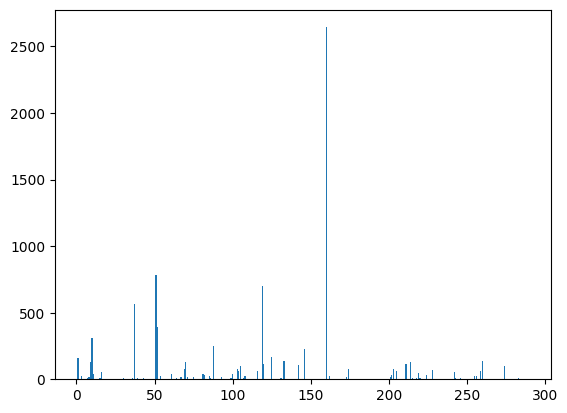

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt 
ct = Counter(labels)

plt.bar(ct.keys(), ct.values())
plt.show()

In [ ]:
ct

Counter()